# Numerical Solvers

### Matthew Kafker, Jeremy Welsh-Kavan

<hr>

The goal of this project is to build a program for numerically solving various ODEs and PDEs. By validating various numerical methods on DEs with known analytical solutions, we hope to be able to implement these methods for a much larger set DEs.

We start with a naive approach and propagate our solution in time using information from the spatial derivative. This is analogous to the the initial value problem (IVP) in which we hope to solve for $y(t)$ given

$
y'(t) = f(t, y(t)) ~~~~~ y(t_0) = y_0
$

Instead, we are solving for $u(x,t)$ given

$
\partial_t u(x,t) = \partial_{xx} u(x,t) \\
u(x,0) = f(x) \\
u(0,t) = u(L,t) = 0 \\
$

for $x \in [0,L]$ and $t>0$.



[//]: <> (For instructions on how to use LaTeX, see the LaTeX folder, which also contains a few other TeXShop files.)

<hr>

Most of what we implement here will be informed by the following resources:

Asmar, Nakhlé H., and Nakhlé H. Asmar. Partial Differential Equations with Fourier Series and Boundary Value Problems. 2nd ed. Upper Saddle River, N. j: Pearson Prentice Hall, 2005. Print.

Press, William H. Numerical Recipes : the Art of Scientific Computing. Cambridge ;: Cambridge University Press, 1989. Print.

Kutz, Jose Nathan. Data-Driven Modeling & Scientific Computation : Methods for Complex Systems & Big Data. First edition. Oxford: Oxford University Press, 2013. Print.

Libraries and plotting preferences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import jit
from tqdm import tqdm
from IPython.display import clear_output

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = [8, 6]

In [35]:
L = 100
xmin, xmax = 0, L
res = 1024
x_arr = np.linspace(xmin, xmax, res)
dx = (x_arr[1]-x_arr[0])
N = len(x_arr)

kmax = np.pi/dx
kmin = 2*np.pi/L
k_pos = np.arange(0, kmax, kmin)
k_neg = np.arange(-kmax, 0, kmin)
k_arr = np.concatenate([k_pos, k_neg])

In [36]:
k = 1
f_arr = (np.sqrt(k)/np.pi)**(1/4)*np.exp(-np.sqrt(k)*(x_arr-L/2)**2/2)

In [37]:
np.sum((f_arr**2)*dx)

0.9999999999999989

In [38]:
T = 5
dt = 0.001
t_arr  = np.arange(0, T, dt)
s = int(np.ceil(T/dt))

$$i \hbar u_t = -\frac{\hbar^2}{2m}u_{xx} + \frac{1}{2}k x^2 u$$

$\hbar = m = 1$

$$u_t = i\Bigl(\frac{1}{2}u_{xx} -\frac{1}{2}k x^2 u\Bigr)$$

In [39]:
derivmat = np.zeros([N,N],dtype="complex_")
for i in range(N):
    for j in range(N):
        if i!=j:
            derivmat[i,j] = -(2*(np.pi**2)/(N**2 * dx**2))*(-1)**(i-j)/np.sin(np.pi*(i-j)/N)**2
        else:
            derivmat[i,j] = -((np.pi**2)/(3 * dx**2))*(1+2/N**2)

# Compile with jit for faster matmul. WARNING: Jit is extremely temperamental
@jit(nopython=True)
def RHS(u_arr,x_arr,k):

    global derivmat
            
    return 1j*(derivmat@u_arr/2 - k*((x_arr-L/2)**2)*u_arr)

In [40]:
def SE_RK4(f_arr, dx, T, dt,k):
    N = f_arr.shape[0]
    s = int(np.ceil(T/dt))
    u = np.zeros([s,N],dtype="complex_")
    u[0]=f_arr
    for t in tqdm(range(0,s-1)):
        f1 = RHS(u[t], x_arr,k)          
        f2 = RHS(u[t] + f1*dt/2, x_arr,k) 
        f3 = RHS(u[t] + f2*dt/2, x_arr,k) 
        f4 = RHS(u[t] + f3*dt, x_arr,k)   
        u[t+1] = u[t] + (dt/6)*(f1 + 2*f2 + 2*f3 + f4)
        norm = np.sum((np.abs(u[t+1])**2)*dx)
        u[t+1] = u[t+1]/norm
    return u

In [50]:
u_RK4 = SE_RK4(f_arr, dx, T, dt, k)

100%|██████████████████████████████████████████████████████████| 4999/4999 [00:08<00:00, 620.98it/s]


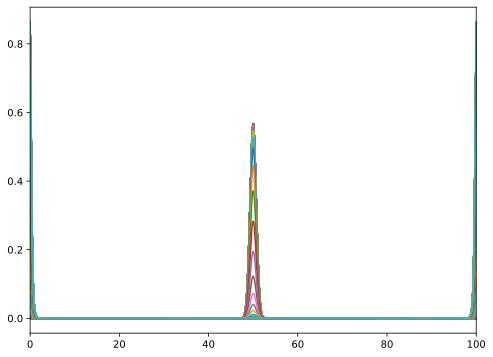

In [52]:
for i in range(200):
    plt.plot(x_arr, np.abs(u_RK4[i,:])**2)
plt.xlim(0,L)
plt.show()

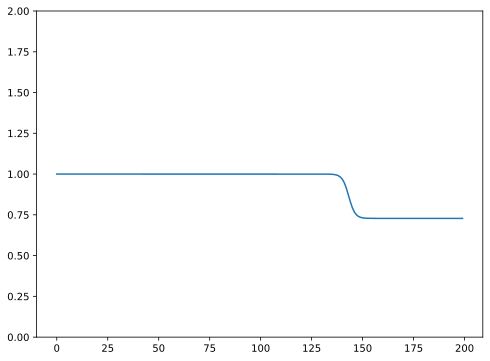

In [26]:
norm_list = np.array([np.sum((np.abs(u_RK4[t])**2)*dx) for t in range(200)])
plt.plot(norm_list)
plt.ylim(0,2)
plt.show()
#norm_list

In [8]:
u_FS = np.array([(2*np.pi*(2*D*t + sig**2))**(-0.5)*np.exp(-((x_arr-L/2)**2.0)/(2*(2*D*t + sig**2))) for t in t_arr])

In [9]:
np.max(np.abs(u_FS - u_RK4))/np.max(np.abs(u_FS))

5.1285035165472296e-14

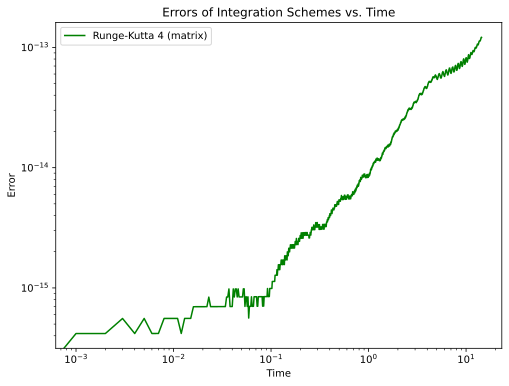

In [10]:
plt.loglog(t_arr,
           np.array([np.max(np.abs(u_RK4[t]-u_FS[t]))/np.max(np.abs(u_FS[t])) for t in range(s)]),
           "g",
           label="Runge-Kutta 4 (matrix)")

plt.ylabel("Error")
plt.xlabel("Time")
plt.title("Errors of Integration Schemes vs. Time")
plt.legend(loc="upper left")
plt.show()

In [11]:
g_arr =  (1/2)*((2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr-L/2 + L/16)**2.0)/(2*sig**2))) + (1/2)*((2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr-L/2 - L/16)**2.0)/(2*sig**2)))

In [12]:
(g_arr*dx).sum()

0.9999999999999998

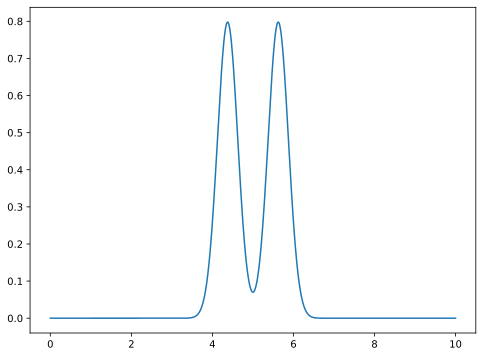

In [13]:
plt.plot(x_arr, g_arr);

In [14]:
u_RK4_bimodal = diffusion_RK4(g_arr, dx, T, dt, D)

100%|██████████| 14407/14407 [01:10<00:00, 204.95it/s]


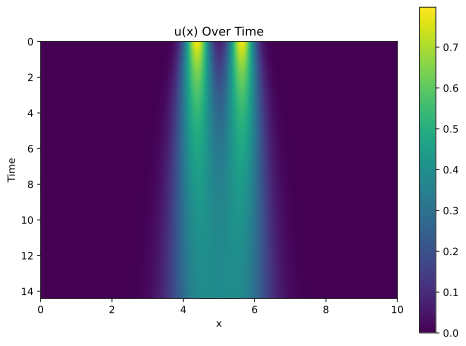

In [15]:
plt.imshow(u_RK4_bimodal,aspect="0.5",extent=[0,L,T,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

In [16]:
h_arr =  (2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr-L/4)**2.0)/(2*sig**2))

In [17]:
(h_arr*dx).sum()

1.0

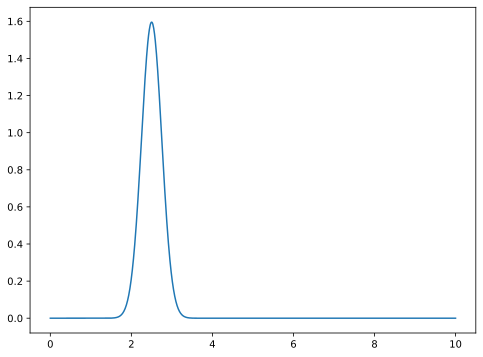

In [18]:
plt.plot(x_arr, h_arr);

In [19]:
u_RK4_offset = diffusion_RK4(h_arr, dx, T, dt, D)

100%|██████████| 14407/14407 [01:06<00:00, 217.80it/s]


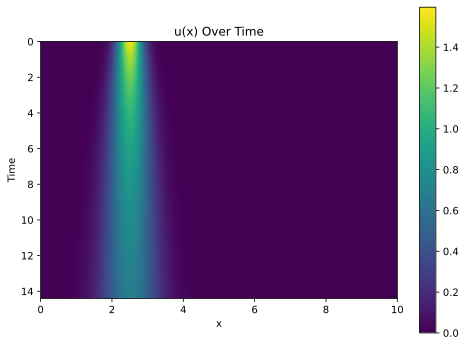

In [20]:
plt.imshow(u_RK4_offset,aspect="0.5",extent=[0,L,T,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()